In [1]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
path = Path('../data/asd/raw')
freqs = np.linspace(4, 12, 41)

info = pd.read_csv(path / 'path_file.csv')
info['fn'] = info['fn'].str.replace('и' + chr(774), 'й') # For some reason, filenames encode й as 2 unicode characters
info = info.groupby("fn").filter(lambda x: len(x) == 1)
info.reset_index(drop=True, inplace=True)
typical = np.where(info['target'] == 'typical')[0]
asd = np.where(info['target'] == 'asd')[0]

eegs = {i: mne.io.read_raw_fif(path / fn, verbose=False) for i, fn in info['fn'].items()}
ch_names = eegs[0].ch_names

assert np.all([eegs[i].info['sfreq'] == sfreq for i, sfreq in info['sfreq'].items()])
info

,fn,target,dataset_name,sfreq,age,seconds
0,sedrykyn_sasha_7_og_concat_19.raw.fif,asd,asd,125,7,47.0
1,roma gritchin _5_fon_open_19.raw.fif,asd,asd,125,5,33.0
2,boy5_asd_og_new_19.raw.fif,asd,asd,125,5,50.0
3,viflyancev_4_asd_fon__concat_19.raw.fif,asd,asd,125,4,58.0
4,andrey_matveev3_asd_new_19.raw.fif,asd,asd,125,3,50.0
...,...,...,...,...,...,...
322,artem_sarkis_6_fon_19.raw.fif,typical,typical,125,6,44.0
323,gusarova_9_norm_19.raw.fif,typical,typical,125,9,83.0
324,акулов миша 10 от даши_ог_19.raw.fif,typical,typical,125,10,42.0
325,жавнис_3_19.raw.fif,typical,typical,125,3,386.0


In [8]:
indices_1 = [index_1(eeg[:][0], age) for eeg, age in zip(eegs.values(), info['age'].values)]
indices_2 = [index_2(eeg[:][0], age) for eeg, age in zip(eegs.values(), info['age'].values)]

KeyboardInterrupt: 

In [9]:
def plot_index(eeg, index, threshold, ax):
    signal, times = eeg

    mask = index(signal, 7).ravel() > threshold
    ax.plot(times, signal.ravel())
    start_ix, end_ix = find_borders(mask)
    for start, end in zip(times[start_ix], times[end_ix]):
        ax.axvspan(start, end, color='r', alpha=.1)


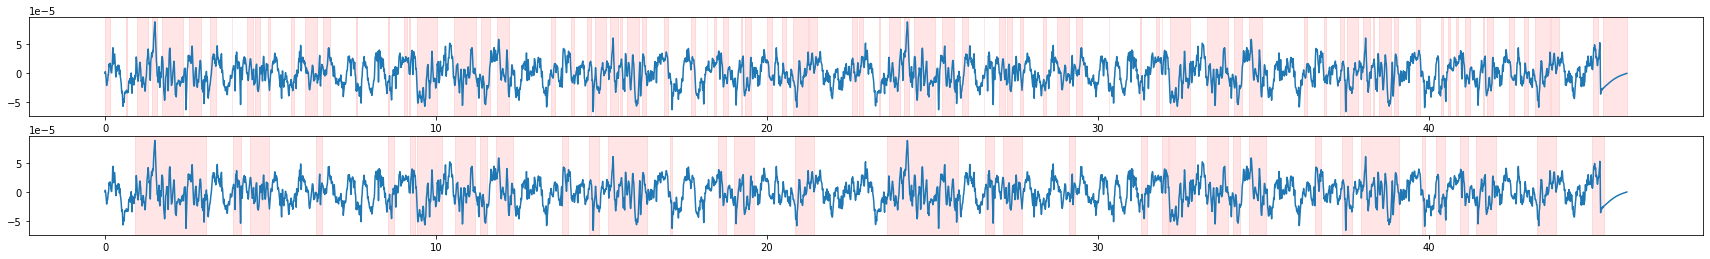

In [10]:
plt.figure(figsize=(30, 4))
plot_index(eegs[67]['Cz'], index_1, 11, plt.subplot(2, 1, 1))
plot_index(eegs[67]['Cz'], index_2, 900, plt.subplot(2, 1, 2))

In [16]:
import seaborn as sns
mean_indices_1 = np.array([x.mean() for x in indices_1])
sns.kdeplot(mean_indices_1[info['target'] == 'typical'])
sns.kdeplot(mean_indices_1[info['target'] == 'asd'])

NameError: name 'indices_1' is not defined

Effective window size : 2.048 (s)


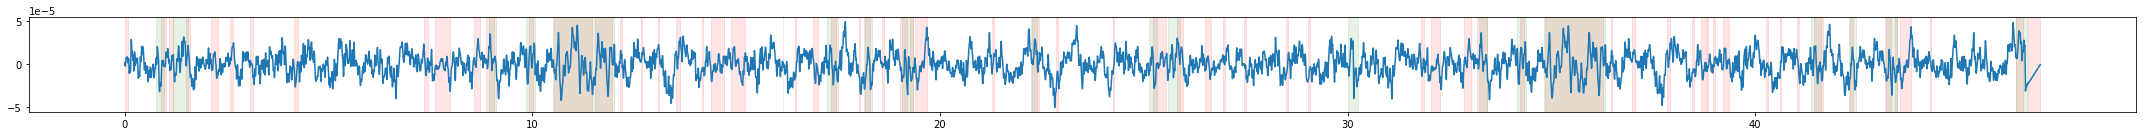

In [91]:
plt.figure(figsize=(30, 2))
signal, times = eegs[0]['F3']

mask_1 = compute_index_1(signal, 7).ravel() > 10
mask_2 = compute_index_2(signal, 7).ravel() > 1000

plt.plot(times, signal.ravel())
start_ix, end_ix = find_borders(mask_1)
for start, end in zip(times[start_ix], times[end_ix]):
    plt.axvspan(start, end, color='r', alpha=.1)
start_ix, end_ix = find_borders(mask_2)
for start, end in zip(times[start_ix], times[end_ix]):
    plt.axvspan(start, end, color='green', alpha=.1)
plt.tight_layout()

In [44]:
from numpy.lib.stride_tricks import sliding_window_view

def sliding_window_apply(func, data, window_size, pad_mode=None, overlap=False):
    if pad_mode is not None:
        data = np.pad(data, (window_size // 2, (window_size - 1) // 2), mode=pad_mode)
    data = sliding_window_view(data, window_size)
    if not overlap:
        data = data[::window_size]
    return func(data, axis=1)

    

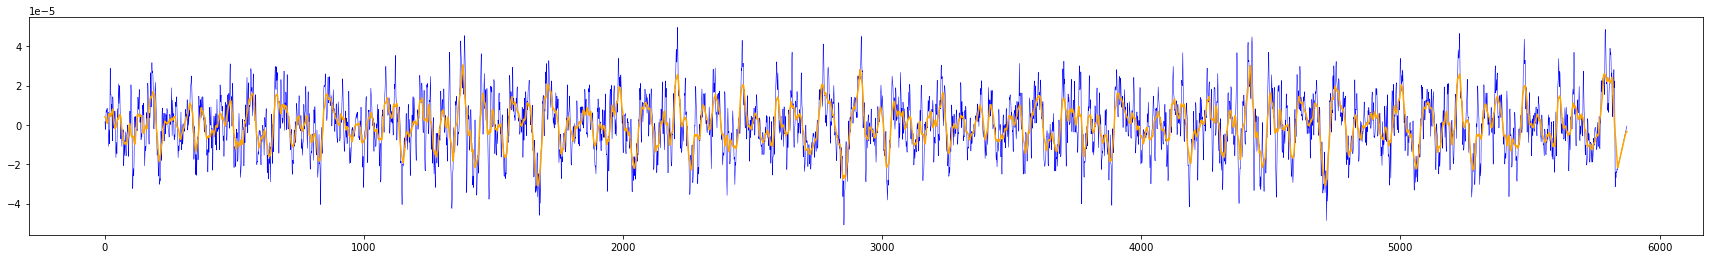

In [91]:
fig = plt.figure(figsize=(30, 4))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(ts, c='blue', lw=.5)
ax1.plot(sliding_window_apply(np.mean, ts, 20, 'symmetric', overlap=True), c='orange', lw=1.5)